<a href="https://colab.research.google.com/github/kokchun/Deep-learning-AI21/blob/main/Lectures/Lec4-Data_augmentation.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; for interacting with the code


---
# Lecture notes - Data augmentation
---

This is the lecture note for **data augmentation**. 

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to data augmentation. I encourage you to read further about data augmentation. </p>

Read more:

- [ImageDataGenerator - TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?version=nightly)
- [Data augmentation - wikipedia](https://en.wikipedia.org/wiki/Data_augmentation)

---

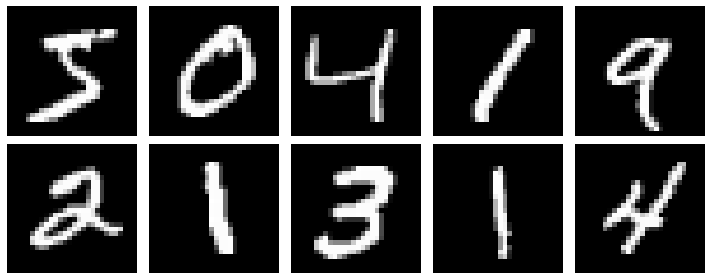

In [56]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import load_data
import os

(X_train, y_train), (X_test, y_test) = load_data()
y_train, y_test = y_train.ravel(), y_test.ravel()

def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(X_train)


In [57]:

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
print(f"{X_train.min()=}, {X_train.max()=}")

X_train.min()=0.0, X_train.max()=1.0


---
## Train|val|test split

In [54]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1 / 6, random_state=42
)

In [60]:
# ImageDataGenerator requires rank 4 
X_train_val = X_train_val[:,:,:,None]
X_val = X_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

X_train_val.shape

(50000, 28, 28, 1)

---
## Data augmentation
- ImageDataGenerator to augment images

In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.style.use("seaborn-white")

train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.2,
    width_shift_range=0.2,
)
# don't augment test data and validation data as we want to test on original data
# we just instantiate an ImageDataGenerator without augmentation
test_image_generator = ImageDataGenerator()

# batch size 32 for mini-batch gradient descent 
train_val_generator = train_image_generator.flow(
    X_train_val, y_train_val, batch_size=32
)

# batch size 32 for mini-batch gradient descent 
train_generator = train_image_generator.flow(
    X_train, y_train, batch_size=32
)

val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

# NumpyArrayIterator
train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x13d88e2e0>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x13dadc790>)

2
(32, 28, 28, 1)


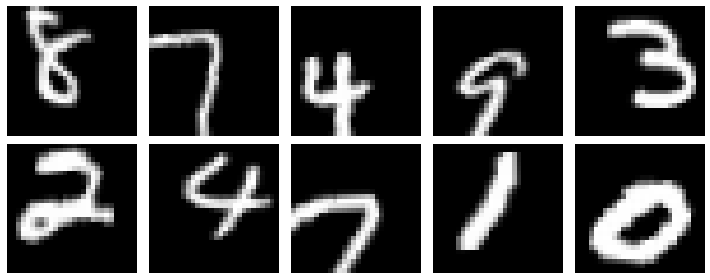

In [70]:
# an iterator can be iterated with a loop as the loop is calling the next() method
print(len(train_val_generator.next())) # tuple of (X_train_val, y_train_val)
print(train_val_generator.next()[0].shape) # 32 samples in a batch of images of
# shape (32,32,3)

plot_samples(train_val_generator.next()[0])


---
## CNN model 

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = CNN_model(drop_rate=.5)

model.summary()


Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dropout_1 (Dropout)         (None, 800)               0 

## Train on augmented data

 - steps_per_epoch is the number of times we generate our data from the generator
 - since we have batches on 32 samples for each time we generate, we could count how many samples before we cover original data size
 - 50000/32 = 

In [74]:
steps_per_epochs = len(X_train_val)/32
validation_steps = len(X_val)/32


312.5

In [75]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)

model.fit(
    train_val_generator,
    steps_per_epoch=1500,
    epochs=100,
    callbacks=[early_stopper],
    validation_data=val_generator,
    validation_steps=312,
)


Epoch 1/100
1500/1500 [==============================] - 27s 17ms/step - loss: 0.6361 - acc: 0.7896 - val_loss: 0.1461 - val_acc: 0.9545
Epoch 2/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2832 - acc: 0.9096 - val_loss: 0.0749 - val_acc: 0.9767
Epoch 3/100
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2269 - acc: 0.9279 - val_loss: 0.0858 - val_acc: 0.9734
Epoch 4/100
1500/1500 [==============================] - 30s 20ms/step - loss: 0.1895 - acc: 0.9407 - val_loss: 0.0642 - val_acc: 0.9801
Epoch 5/100
1500/1500 [==============================] - 28s 19ms/step - loss: 0.1759 - acc: 0.9442 - val_loss: 0.0494 - val_acc: 0.9843
Epoch 6/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.1615 - acc: 0.9494 - val_loss: 0.0455 - val_acc: 0.9861
Epoch 7/100
1500/1500 [==============================] - 28s 19ms/step - loss: 0.1499 - acc: 0.9521 - val_loss: 0.0542 - val_acc: 0.9841
Epoch 8/100
1500/1500 [==================

In [76]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,acc,val_loss,val_acc
0,0.636094,0.789617,0.146052,0.954527
1,0.283237,0.909553,0.074941,0.976663
2,0.226887,0.927872,0.085836,0.973357
3,0.189543,0.940709,0.064238,0.980068
4,0.175880,0.944229,0.049433,0.984275


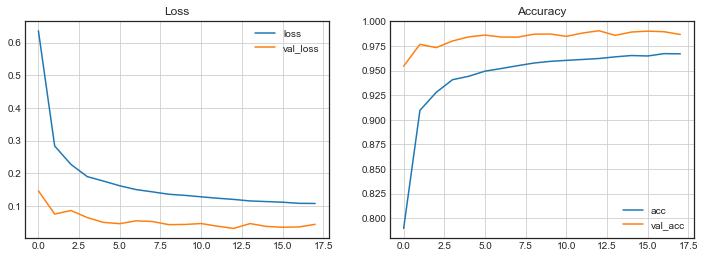

In [77]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

plot_metrics(metrics)
# val accuracy is higher than train accuracy, probably due to train data being
# augmented, which gives a lot of varieties in data and is harder to overfit

---
## Train on all training data

In [80]:
model = CNN_model()
model.fit(
    train_generator,
    steps_per_epoch=1500,
    epochs=18,
)


Epoch 1/18
1500/1500 [==============================] - 27s 17ms/step - loss: 0.6498 - acc: 0.7859
Epoch 2/18
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2829 - acc: 0.9102
Epoch 3/18
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2235 - acc: 0.9300
Epoch 4/18
1500/1500 [==============================] - 28s 19ms/step - loss: 0.1868 - acc: 0.9409
Epoch 5/18
1500/1500 [==============================] - 25s 17ms/step - loss: 0.1696 - acc: 0.9470
Epoch 6/18
1500/1500 [==============================] - 25s 17ms/step - loss: 0.1613 - acc: 0.9486
Epoch 7/18
1500/1500 [==============================] - 25s 17ms/step - loss: 0.1492 - acc: 0.9532
Epoch 8/18
1500/1500 [==============================] - 25s 17ms/step - loss: 0.1451 - acc: 0.9549
Epoch 9/18
1500/1500 [==============================] - 25s 17ms/step - loss: 0.1308 - acc: 0.9594
Epoch 10/18
1500/1500 [==============================] - 25s 17ms/step - loss: 0.1302 - acc: 0.9595
Epoch 11/

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      1.00      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



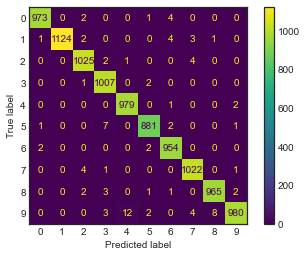

In [81]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

y_pred = model.predict(X_test)
#y_pred = np.argmax(y_pred)

y_pred = np.argmax(y_pred, axis = 1)


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

---

Kokchun Giang

[LinkedIn][linkedIn_kokchun]

[GitHub portfolio][github_portfolio]

[linkedIn_kokchun]: https://www.linkedin.com/in/kokchungiang/
[github_portfolio]: https://github.com/kokchun/Portfolio-Kokchun-Giang

---
